# Generative and Discriminative Models

The goal is the comparison of the Naïve Bayes Classifier (NBC) and Logistic Regression based on the paper mentioned below. Concretely, some of the experimental results are qualitatively reproduced. The comparison is performed on six datasets.

**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

## Naïve Bayes Classifier (NBC)

The implementation is based on the assumption that the data has three different features: the first being binary, the second being continous, and the third being categorical. Furthermore, four target classes are assumed. Similar to the classifiers provided in sklearn, the custom implementation of the NBC implements a **fit** and a **predict** function. 

Recalling the joint distribution of a generative model, $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$, the fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

In [3]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
import pandas as pd
from scipy.stats import norm, multinomial, bernoulli
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import requests
from io import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss, mean_squared_error
from statistics import mean 
from sklearn.model_selection import train_test_split
#from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm.notebook import tqdm
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

In [4]:
# Distribution for continuous features
class ContFeatureParam:
    def __init__(self):
        self.gauss = norm()
        
    def estimate(self, X):       
        assert X.ndim == 1 or X.ndim == 0, "Only one feature accepted"
        
        # parameter estimation and distribution initialization
        # TODO: implement MLE for parameters
        mu = X.mean()
        sigma  = X.var() if X.var() != 0 else 1e-6
        self.gauss = norm(mu,sigma)
        #print("Parameters estimated: Mu = {}, Sigma = {}".format(mu, sigma))

    def get_probability(self, val):      
        return self.gauss.logpdf(val)


# Distribution for binary features
class BinFeatureParam:
    def __init__(self):
        self.bernoulli = bernoulli(p=0)
    
    def estimate(self, X):       
        assert X.ndim == 1 or X.ndim == 0, "Only one feature accepted"
        
        # parameter estimation and distribution initialization
        prob_succ = (np.count_nonzero(X == 1))/(X.size)
        self.bernoulli = bernoulli(p=prob_succ)
        #print("Parameters estimated: p = {}".format(prob_succ))

    def get_probability(self, val):
        # return probability value in log space
        return self.bernoulli.logpmf(val)

    
# Distribution for categorical features
class CatFeatureParam:
    def __init__(self):
        self.multinoulli = multinomial(n=1, p=[0.5, 0.5])
        self.enc = OrdinalEncoder()
        
    def estimate(self, X):
        assert X.ndim == 1 or X.ndim == 0, "Only one feature accepted"
        
        # encode categorical data using scikit ordinal encoder
        df = pd.DataFrame(data=(self.enc.fit_transform(X.reshape(-1,1))), columns=['encoding'])
        df_sort = pd.DataFrame(df['encoding'].value_counts()).rename(columns={'encoding':'counts'}).sort_index()
        
        # parameter estimation and distribution initialization
        params = (df_sort['counts'].to_numpy())/(df_sort['counts'].to_numpy().sum())
        self.multinoulli = multinomial(n=1, p=params)
        #print("Parameters estimated: p = {}".format(params)) 
        
    def get_probability(self, val):
        method_param = np.zeros([len(val), len(self.enc.categories_[0])])
        
        # encoding input value
        val_enc = self.enc.transform(np.array(val).reshape(-1,1))
        method_param[np.arange(len(method_param)), np.squeeze(val_enc.astype(int))] = 1
    
        # return probability value in log space
        return self.multinoulli.logpmf(method_param)

### Implementation of NBC Class

**Function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. The question is how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$.

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

**Function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

What about the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$? Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

In [5]:
class NBC:
    def init_dist(self, feat_type):
        if feat_type == 'b': 
            return BinFeatureParam()
        elif feat_type == 'r':
            return ContFeatureParam()
        elif feat_type == 'c':
            return CatFeatureParam()
        else:
            raise ValueError("Invalid feature type. Supported are 'b', 'r', and 'c'.")
    
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):
        # initialize instance variables
        self.feature_types = feature_types
        self.num_classes = num_classes
        self.label_enc = LabelEncoder()
        self.class_data = {}
        self.dist_features = {}
        self.dist_labels = []
        
        for i in range(num_classes):
            self.dist_features[str(i)] = {}
            for j, el in enumerate(feature_types):
                self.dist_features[str(i)][str(j)] = self.init_dist(str(el))
                
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # sanity checks: does data correspond to initialization values?
        assert X.shape[1] == len(self.feature_types) and np.unique(y).size == self.num_classes, "Data does not correspond to class initialization. Check number of features and label classes."
        assert X.shape[0] == y.shape[0], "Shape mismatch: number of datapoints in X differ from number of elements in label vector y."
        
        # label encoding
        y_enc = self.label_enc.fit_transform(y)
        
        # prepare class specific datasets
        for i in np.unique(y_enc):
            self.class_data[str(i)] = X[np.where(y_enc == i)[0]]
            
        # fit feature distributions
        for i in np.unique(y_enc):
            for j, el in enumerate(self.feature_types):
                self.dist_features[str(i)][str(j)].estimate(self.class_data[str(i)][:,j])
        
        # fit label distribution
        df = pd.DataFrame(data=y_enc, columns=['labels_enc'])
        df_sort = pd.DataFrame(df['labels_enc'].value_counts()).rename(columns={'labels_enc' : 'counts'}).sort_index()
        self.dist_labels = df_sort['counts'].to_numpy()/(df_sort['counts'].to_numpy().sum())
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X, return_y_original=False):
        # sanity check: number of input features = number of initialized distributions?
        assert X.shape[0] == len(self.feature_types) or X.shape[1] == len(self.feature_types), "Shape mismatch: number of input features != number of initialized distributions"
        
        # option to return predicted labels in inverted form 
        label_original = return_y_original
        
        # initialize numerators of Bayes rule and ŷ
        # since computations are done in log space, it holds that:
        # log(P(class_i | data)) ∝ log(P(class_i)) + Σ_j (log(P(x_j | class_i)))
        if X.ndim == 1:
            X = np.reshape(X, (1,-1))
            numerators = np.ones([1, self.num_classes])
            y_predict = np.zeros(1)
        elif X.ndim == 2:
            numerators = np.ones([X.shape[0], self.num_classes])
            y_predict = np.zeros(X.shape[0])
        else:
            raise ValueError("Invalid dimension of input data")
        
        # compute posteriors
        for i in range(self.num_classes):
            numerators[:,i] += np.log(self.dist_labels[i])
            for j, el in enumerate(self.feature_types):
                numerators[:,i] += self.dist_features[str(i)][str(j)].get_probability(X[:,j])

        # filter most likely class
        y_predict = np.argmax(numerators, axis=1)
        
        # return predicted labels
        return y_predict if not return_y_original else self.label_enc.inverse_transform(y_predict)

In [9]:
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)
print("Accuracy:", test_accuracy)

Accuracy: 0.9666666666666667


## Comparing NBC and Logistic Regression (LR)

The idea is to compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, we do this multiple times and
average the classification error. One run looks as follows:
- Shuffle the data, put 20% aside for testing.
- Train the classifiers with increasingly more data (e.g., 10%, 20%, ..., 100% of training data) and store the classification errors on the test set

We repeat this with at least 200 random permutations to average out the test error across the runs. In the end, we get average test errors as a function of the size of the training data.

**Parameters of the comparison**

In [18]:
TRAIN_SET_RATIO = 0.8
NUM_RUNS = 500
NUM_SPLITS = 10
LR_MAX_ITER = 1000

In [19]:
def shuffle_split_data(X, y, ratio):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=ratio * TRAIN_SET_RATIO,
        test_size=ratio * (1 - TRAIN_SET_RATIO),
        stratify=y,
        shuffle=True
    )
    
    return X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [20]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=NUM_RUNS, num_splits=NUM_SPLITS):
    nbc_test_errors = []
    lr_test_erorrs = []
    
    for ratio in np.arange(0.1, 1.1, 1/num_splits):
        print('Training with {}% of data'.format(int(ratio * 100)))
        nbc_test_error_measurements = []
        lr_test_error_measurements = []
        
        # Repeat measurement for a particular ratio and take average error
        for i in tqdm(range(num_runs)):
            X_train, X_test, y_train, y_test = shuffle_split_data(X, y, ratio)
                    
            nbc.fit(X_train, y_train)
            lr.fit(X_train, y_train)
            
            nbc_error = hamming_loss(y_test, nbc.predict(X_test))
            lr_error = hamming_loss(y_test, lr.predict(X_test))
            
            nbc_test_error_measurements.append(nbc_error)
            lr_test_error_measurements.append(lr_error)
        
        nbc_test_errors.append(mean(nbc_test_error_measurements))
        lr_test_erorrs.append(mean(lr_test_error_measurements))
        
    return nbc_test_errors, lr_test_erorrs

In [21]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

In [22]:
def read_df_by_url(url):
    response = requests.get(url)
    data = response.content.decode('utf8')
    
    return pd.read_csv(StringIO(data), header=None)

### Datasets

Idea: for each dataset...
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

Training with 10% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 20% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 30% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 40% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 50% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 60% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 70% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 80% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 90% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 100% of data


  0%|          | 0/500 [00:00<?, ?it/s]

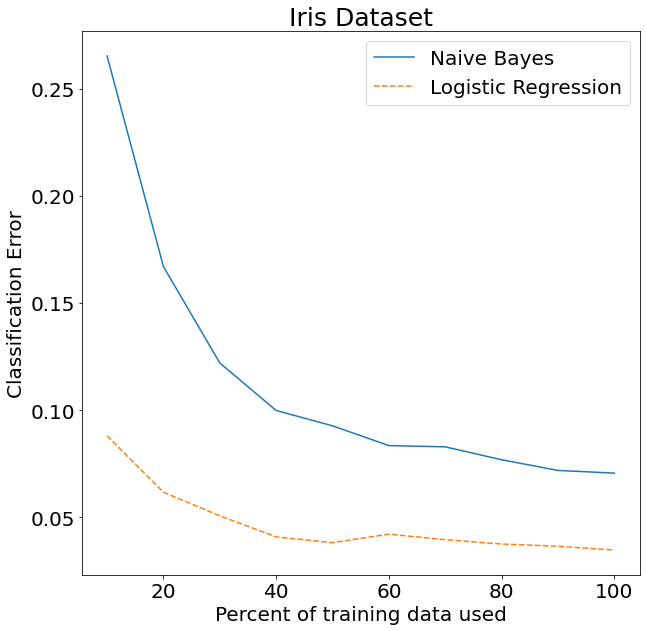

In [23]:
iris_obj = load_iris()
df = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
X = df.drop(['species'], axis=1)
y = df['species']

nbc = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
lr = LogisticRegression(max_iter=LR_MAX_ITER)

makePlot(*compareNBCvsLR(nbc, lr, X, y), title='Iris Dataset')

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

Training with 10% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 20% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 30% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 40% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 50% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 60% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 70% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 80% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 90% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 100% of data


  0%|          | 0/500 [00:00<?, ?it/s]

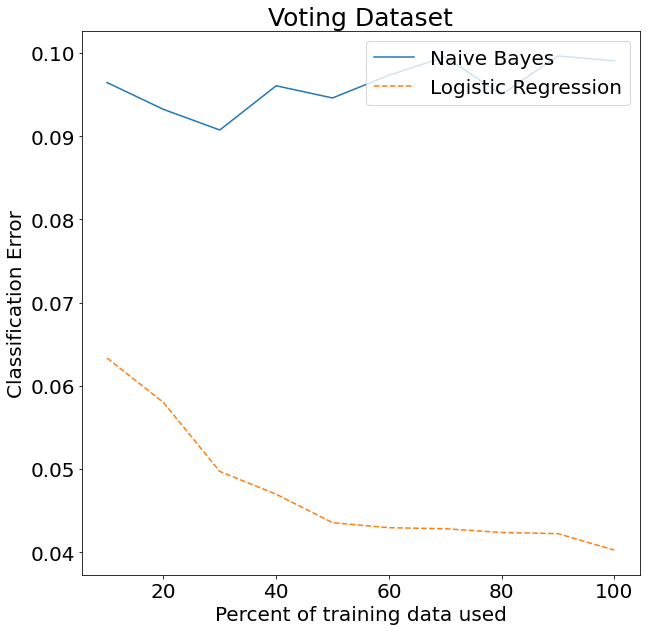

In [24]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'
df = read_df_by_url(url)
X = df.drop([0], axis=1)
y = df[0]
imputer = SimpleImputer(missing_values='?', strategy='most_frequent')
X[:] = imputer.fit_transform(X)
X = pd.get_dummies(X)
y = pd.Series(LabelEncoder().fit_transform(y))
num_features = X.shape[1]
num_classes = len(np.unique(y))

nbc = NBC(feature_types=['b'] * num_features, num_classes=num_classes)
lr = LogisticRegression(max_iter=LR_MAX_ITER)

makePlot(*compareNBCvsLR(nbc, lr, X, y), title='Voting Dataset')

**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

Training with 10% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 20% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 30% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 40% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 50% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 60% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 70% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 80% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 90% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 100% of data


  0%|          | 0/500 [00:00<?, ?it/s]

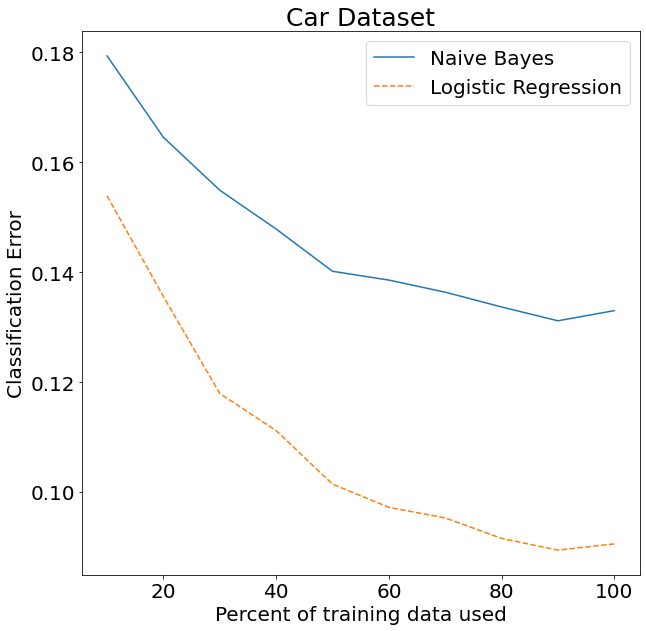

In [25]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
df = read_df_by_url(url)
X = df.drop(df.columns[-1], axis=1)
X = pd.get_dummies(X)
y = df[df.columns[-1]]
y = pd.Series(LabelEncoder().fit_transform(y))
num_features = X.shape[1]
num_classes = len(np.unique(y))

nbc = NBC(feature_types=['b'] * num_features, num_classes=num_classes)
lr = LogisticRegression(max_iter=LR_MAX_ITER)

makePlot(*compareNBCvsLR(nbc, lr, X, y), title='Car Dataset')

**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

Training with 10% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 20% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 30% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 40% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 50% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 60% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 70% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 80% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 90% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 100% of data


  0%|          | 0/500 [00:00<?, ?it/s]

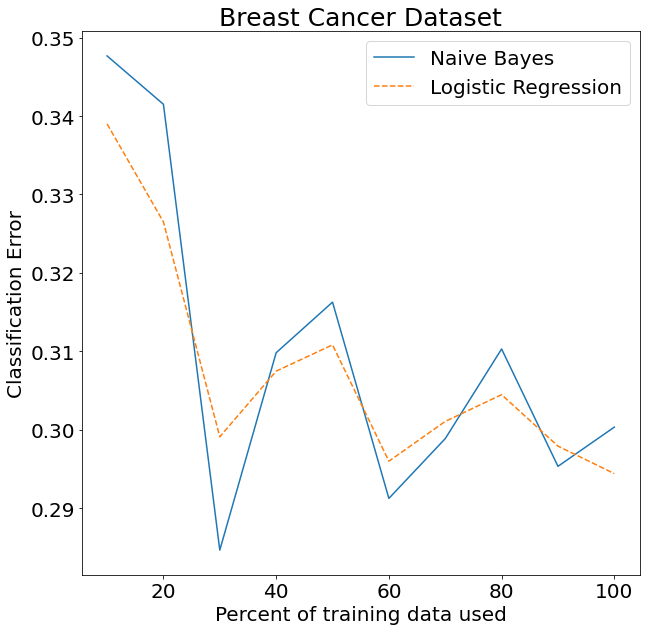

In [26]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data'
df = read_df_by_url(url)
X = df.drop([0], axis=1)
X = pd.get_dummies(X)
y = df[df.columns[0]]
y = pd.Series(LabelEncoder().fit_transform(y))
num_features = X.shape[1]
num_classes = len(np.unique(y))

nbc = NBC(feature_types=['b'] * num_features, num_classes=num_classes)
lr = LogisticRegression(max_iter=LR_MAX_ITER)

makePlot(*compareNBCvsLR(nbc, lr, X, y), title='Breast Cancer Dataset')

**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

Training with 10% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 20% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 30% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 40% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 50% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 60% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 70% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 80% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 90% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 100% of data


  0%|          | 0/500 [00:00<?, ?it/s]

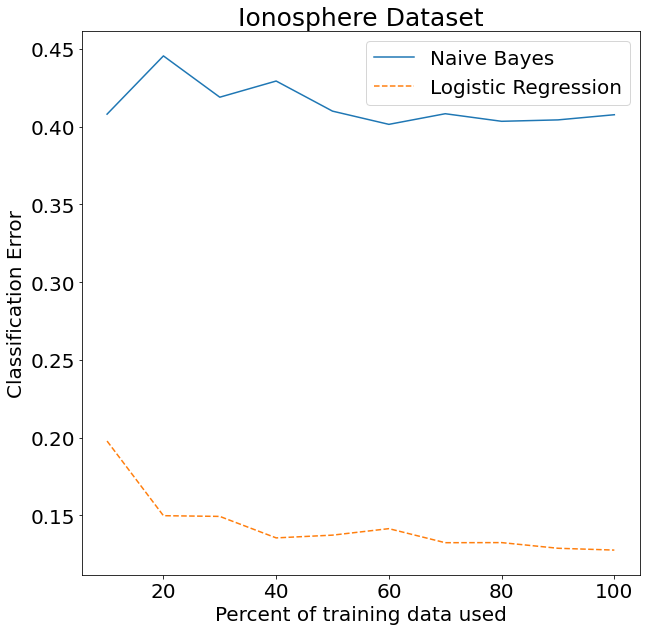

In [27]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data'
df = read_df_by_url(url)
X = df.drop(df.columns[-1], axis=1)
y = df[df.columns[-1]]
y = pd.Series(LabelEncoder().fit_transform(y))
num_features = X.shape[1]
num_classes = len(np.unique(y))

nbc = NBC(feature_types=['r'] * num_features, num_classes=num_classes)
lr = LogisticRegression(max_iter=LR_MAX_ITER)

makePlot(*compareNBCvsLR(nbc, lr, X, y), title='Ionosphere Dataset')

**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

Training with 10% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 20% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 30% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 40% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 50% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 60% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 70% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 80% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 90% of data


  0%|          | 0/500 [00:00<?, ?it/s]

Training with 100% of data


  0%|          | 0/500 [00:00<?, ?it/s]

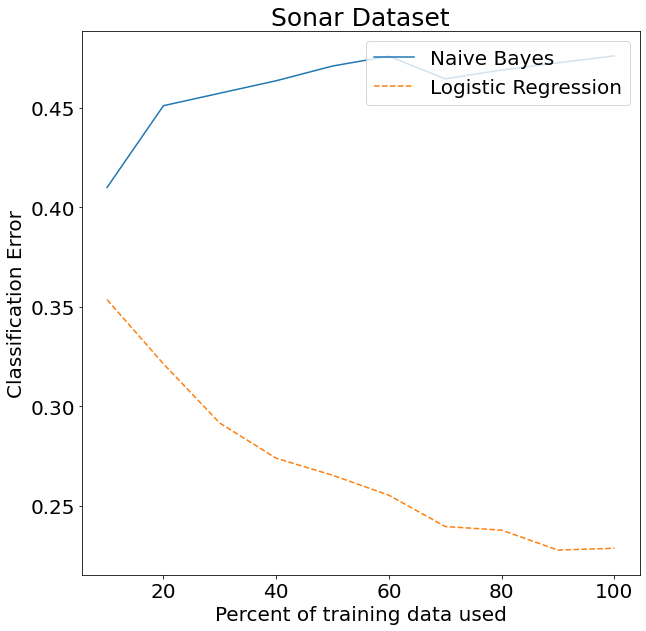

In [28]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
df = read_df_by_url(url)
X = df.drop(df.columns[-1], axis=1)
y = df[df.columns[-1]]
y = pd.Series(LabelEncoder().fit_transform(y))
num_features = X.shape[1]
num_classes = len(np.unique(y))

nbc = NBC(feature_types=['r'] * num_features, num_classes=num_classes)
lr = LogisticRegression(max_iter=LR_MAX_ITER)

makePlot(*compareNBCvsLR(nbc, lr, X, y), title='Sonar Dataset')